# Medical Imaging
## 2020-2021

### Lab 6

### Group 13:
- Alexandra Gonçalves | nº89785
- Catarina Carvalho   | nº89791
- Diogo Vieira        | nº89794
- Mariana Mourão      | nº98473

### Importing relevant libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema

### Define Constants

In [2]:
# CONSTANTS 

T1    = 700e-3;       # Longitudinal decay constant [s]
T2    = 70e-3;        # Transverse decay constant [s] 
TE    = 1e-3;         # Echo time [s]
TR    = 1000e-3;      # Repetition time [s] 
dT    = 1e-3;         # Time step [s]  
theta = 75*np.pi/180; # Excitation angle [rad]
M0    = [0,0,1];      # Equilibrium magnetization vector
NEX   = 10;           # Total nº of excitations / repetitions
inv_angle = np.pi;    # Inversion angle in rad

# 1) Pulse Sequence Diagram over the total study duration

Text(0.5, 1.0, 'Pulse sequence diagram: zoom-in')

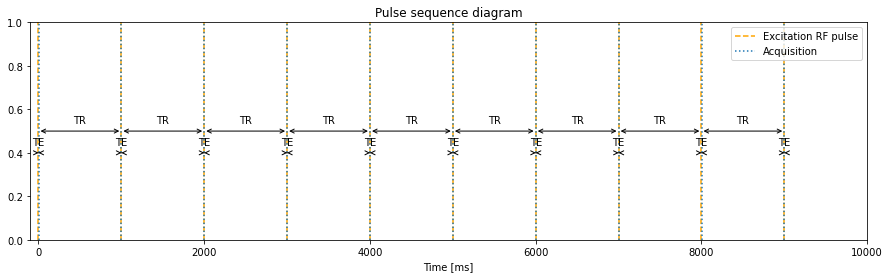

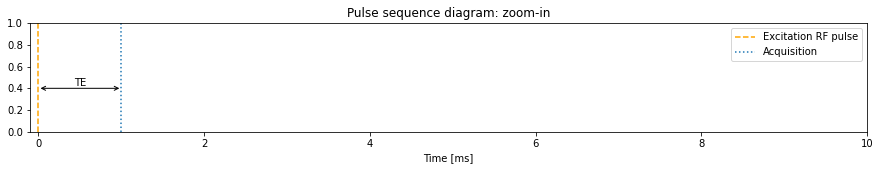

In [3]:
time_samples = np.linspace(0,(TR/dT)*NEX,int((TR/dT)*NEX) + 1)  # vector with the time samples

acquisition_times = []  # vector with the acquisition points in time
excitation_times = [] # vector with the excitation pulse time points

for repetition_no in range(NEX):  # for each repetition, add the times to the lists
    acquisition_times.append( (repetition_no * TR + TE) / dT)
    excitation_times.append(repetition_no * TR / dT)


# Full plot --------------------------------------------------

fig, ax = plt.subplots(1,1,figsize=(15,4))
# Mark the excitation times
for times in excitation_times:
    if excitation_times.index(times) == 0:
        plt.axvline(x=times, color = 'orange', linestyle='--', label = 'Excitation RF pulse')
    else:
        plt.axvline(x=times, color = 'orange', linestyle='--')

# Mark the acquisition times
for times in acquisition_times:
    if acquisition_times.index(times) == 0:
        plt.axvline(x=times, linestyle='dotted', label = 'Acquisition')
    else:
        plt.axvline(x=times, linestyle='dotted')

# Add the arrows
for times in range(1, len(excitation_times)):
    TR_arrow_x = excitation_times[times-1]
    TR_arrow_dx = excitation_times[times]
    #plt.arrow(x=TR_arrow_x, y=0.5, dx=TR_arrow_dx, dy=0, color = 'orange', head_width=100, head_length=50)
    ax.annotate('', xy=(TR_arrow_x, 0.5), xytext=(TR_arrow_dx,0.5), arrowprops={'arrowstyle': '<->'})
    ax.annotate('TR', xy=((TR_arrow_dx+TR_arrow_x)/2, 0.55), ha='center', va='center')

for times in range(len(acquisition_times)):
    TE_arrow_x = excitation_times[times]
    TE_arrow_dx = acquisition_times[times]
    #plt.arrow(x=TR_arrow_x, y=0.5, dx=TR_arrow_dx, dy=0, color = 'orange', head_width=100, head_length=50)
    ax.annotate('', xy=(TE_arrow_x, 0.4), xytext=(TE_arrow_dx,0.4), arrowprops={'arrowstyle': '<->'})
    ax.annotate('TE', xy=((TE_arrow_dx+TE_arrow_x)/2, 0.45), ha='center', va='center')


# Plot settings
plt.legend()
plt.xlim(-100, time_samples[-1])
plt.ylim(0, 1)
plt.xlabel('Time [ms]')
plt.title('Pulse sequence diagram')


# Zoom in ------------------------------------------

fig, ax = plt.subplots(1,1,figsize=(15,2))
# Mark the excitation times
for times in excitation_times:
    if excitation_times.index(times) == 0:
        plt.axvline(x=times, color = 'orange', linestyle='--', label = 'Excitation RF pulse')
    else:
        plt.axvline(x=times, color = 'orange', linestyle='--')

# Mark the acquisition times
for times in acquisition_times:
    if acquisition_times.index(times) == 0:
        plt.axvline(x=times, linestyle='dotted', label = 'Acquisition')
    else:
        plt.axvline(x=times, linestyle='dotted')

# Add the arrows
for times in range(1):
    
    TE_arrow_x = excitation_times[0]
    TE_arrow_dx = acquisition_times[0]
    ax.annotate('', xy=(TE_arrow_x, 0.4), xytext=(TE_arrow_dx,0.4), arrowprops={'arrowstyle': '<->'})
    ax.annotate('TE', xy=((TE_arrow_dx+TE_arrow_x)/2, 0.45), ha='center', va='center')
    
# Plot settings
plt.legend()
plt.xlim(-0.1, 10)
plt.ylim(0, 1)
plt.xlabel('Time [ms]')
plt.title('Pulse sequence diagram: zoom-in')

# 2) Total study duration

The total study duration is given by:

$$(\text{NEX} - 1) \times T_R + T_E = $$
$$ = 9 \times 1000 + 1 = $$
$$ = 9001 \text{ms}$$

# 3) Evolution of the longitudinal and transverse magnetization for $TR = 1000\,ms$

In [6]:
def magnetization_vectors(theta,inv_angle,T1,T2,dT,TE,TR,NEX):
    # Define time vector, initialize magnetization matrix and establish starting point
    time   = np.linspace(0,(TR/dT)*NEX,int((TR/dT)*NEX) + 1)
    M      = np.zeros((3,len(time)))
    M[:,0] = M0
    
    # Bloch equation for excitation and relaxation
    Exct = np.array([[1,0,0],[0,np.cos(theta),np.sin(theta)],[0,-np.sin(theta),np.cos(theta)]])
    Relx = [[np.exp(-(dT/T2)), 0, 0],[0, np.exp(-(dT/T2)), 0], [0, 0, np.exp(-(dT/T1))]];
    Add  = [0, 0, np.linalg.norm(M0)*(1-np.exp(-dT/T1))];
    
    # Rotation matrix
    Rot  = np.array([[1,0,0],[0,np.cos(inv_angle),np.sin(inv_angle)],[0,-np.sin(inv_angle),np.cos(inv_angle)]]) 
    #Rot  = np.array([[np.cos(inv_angle),0,-np.sin(inv_angle)],[0,1,0],
    #                [np.sin(inv_angle),0,np.cos(inv_angle)]])   
    
    for i in range(1,NEX*int(TR/dT)):
        if i % int(TR/dT) == 0 or i == 1: # Excitation
            M[:,i] = np.dot(Exct,M[:,i-1])
        else:
            M[:,i] = np.dot(Relx,M[:,i-1]) + Add
        
    return time, M

"\nplt.subplot(3,1,3)\nplt.plot(time,M_arg)\nplt.xlabel('Time [ms]')\nplt.ylabel('$arg(M(t))$')\nplt.title('Phase of $M_{xy}(t)$')\nplt.show()\n"

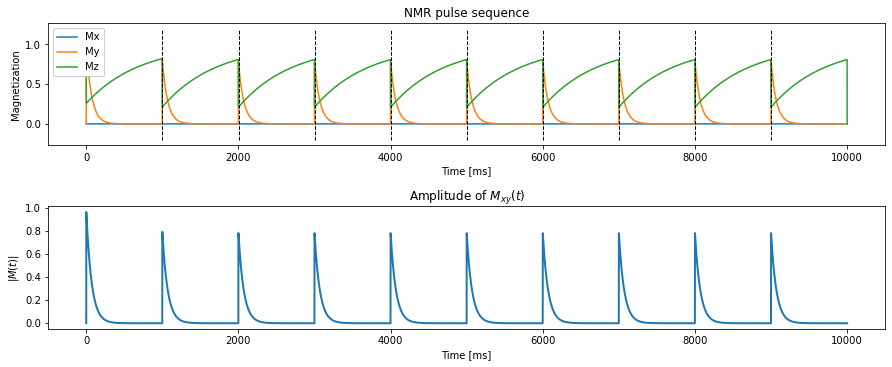

In [26]:
# RESULTS
time, M = magnetization_vectors(theta,inv_angle,T1,T2,dT,TE,TR,NEX);

plt.figure(figsize=(15,9));

# Magnetization plot
plt.subplot(3,1,1)
plt.plot(time, M[0,:], label = 'Mx');
plt.plot(time, M[1,:], label = 'My');
plt.plot(time, M[2,:], label = 'Mz');
for n in range(1,NEX):
    plt.plot([time[int(TR/dT*n+1)], time[int(TR/dT*n+1)]], 
             [np.min([M[0,:], M[1,:], M[2,:]])-0.2, np.max([M[0,:], M[1,:], M[2,:]])+0.2], 
             color='black', linestyle='dashed', linewidth=1);
plt.xlabel('Time [ms]');
plt.ylabel('Magnetization');
plt.title('NMR pulse sequence')
plt.legend(framealpha=1, frameon=True);
plt.subplots_adjust(hspace=0.5)

# Obtain amplitude and phase and plot results 
M_complex = np.zeros((len(M[0])),dtype=complex)
for i in range(len(M[0])):
    M_complex[i] = complex(M[0,i],M[1,i])
    
# Get amplitude and phase
M_abs = abs(M_complex)
M_arg = np.angle(M_complex)

plt.subplot(3,1,2)
plt.plot(time,M_abs,linewidth=2)
plt.xlabel('Time [ms]')
plt.ylabel('$|M(t)|$')
plt.title('Amplitude of $M_{xy}(t)$')
plt.subplots_adjust(hspace=0.5)
"""
plt.subplot(3,1,3)
plt.plot(time,M_arg)
plt.xlabel('Time [ms]')
plt.ylabel('$arg(M(t))$')
plt.title('Phase of $M_{xy}(t)$')
plt.show()
"""

# 4) Transverse magnetization amplitude at each acquisition time

While we have a non-zero transverse magnetization $M_{xy}$, we have a magnetic field in this plane that is rotating around $B_0$. Since this field changes with time, so does its flux over time. Therefore, we have a non-zero electromotive force that generates an electric current, induced on the conducter, that is measured by an ADC that acquires the signal. The signal is acquired in multiples of the echo time $TE$.

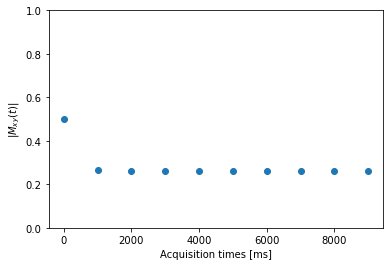

In [36]:
time_acq = []
M_acq    = []
for n in range(0,NEX):
    time_acq = time_acq + [time[int(n*TR/dT+1)]]
    M_acq    = M_acq + [M_abs[int(n*TR/dT+1)]]

plt.scatter(time_acq,M_acq)
plt.xlabel('Acquisition times [ms]')
plt.ylabel('$|M_{xy}(t)|$')
plt.ylim(0, 1)
plt.show()

# 5) Calculation of the steady-state magnetization, $M_{SS}$

**THEORETICAL RESULT**

For a general flip angle $\theta$ < 90º, and assuming the approximation $TR>>T2$, the longitudinal steady-state magnetization after application of the pulse is:

\begin{equation}
    M_{z\_SS} = \frac{M_{0}\big[1-\exp(-TR/T1)\big]}{1-\exp(-TR/T1)\cos\theta} .
\end{equation}

Replacing the constants, we get:

\begin{equation}
    M_{z\_SS} = \frac{1\cdot\big[1-\exp(-1000/700)\big]}{1-\exp(-1000/700)\cos75} \approx 0.811.
\end{equation}



The **transverse** steady-state magnetization after excitation $M_{SS}$ can be obtained using:

\begin{equation}
    M_{SS} = \frac{M_{0}\big[1-\exp(-TR/T1)\big]\sin\theta}{1-\exp(-TR/T1)\cos\theta}\exp\Big(-\frac{TE}{T2}\Big) .
\end{equation}

Replacing the constants, we get:

\begin{equation}
    M_{SS} = \frac{1\cdot\big[1-\exp(-1000/700)\big]\sin75}{1-\exp(-1000/700)\cos75}\exp\Big(-\frac{1}{70}\Big) \approx 0.772
\end{equation}



In [9]:
MzSS_theory = (1-np.exp(-TR/T1))/(1-np.exp(-TR/T1)*np.cos(theta))
print('MzSS = ' + str(MzSS_theory))

MzSS = 0.8106292585603695


In [10]:
MxySS_theory = (1-np.exp(-TR/T1))/(1-np.exp(-TR/T1)*np.cos(theta)) * np.sin(theta)*np.exp(-TE/T2)
print('MxySS = ' + str(MxySS_theory))

MxySS = 0.771901431216791


## EXPERIMENTAL RESULT

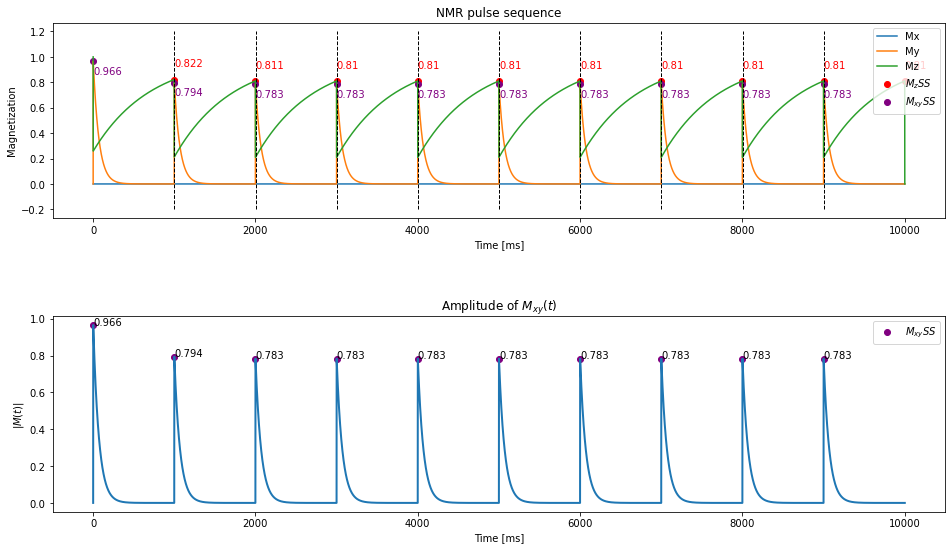

In [11]:
times_MzSS = argrelextrema(M[2,:], np.greater)[0]
MzSS5 = M[2,times_MzSS]

times_MxySS = argrelextrema(M_abs, np.greater)[0]
MxySS5 = M_abs[times_MxySS]

plt.figure(figsize=(16,9));

plt.subplot(2,1,1)
plt.plot(time, M[0,:], label = 'Mx');
plt.plot(time, M[1,:], label = 'My');
plt.plot(time, M[2,:], label = 'Mz');

for n in range(1,NEX):
    plt.plot([time[int(TR/dT*n+1)], time[int(TR/dT*n+1)]], [np.min([M[0,:], M[1,:], M[2,:]])-0.2, np.max([M[0,:], M[1,:], M[2,:]])+0.2], color='black', linestyle='dashed', linewidth=1);
plt.scatter(times_MzSS, MzSS5, color='red', label='$M_zSS$')
for n in range(len(times_MzSS)):
    plt.text(x=times_MzSS[n], y=MzSS5[n]+0.1, s=str(round(MzSS5[n],3)), color = 'red')
plt.scatter(times_MxySS, MxySS5, color='purple', label='$M_{xy}SS$')
for n in range(len(times_MxySS)):
    plt.text(x=times_MxySS[n], y=MxySS5[n]-0.1, s=str(round(MxySS5[n],3)), color='purple')
    
plt.xlabel('Time [ms]');
plt.ylabel('Magnetization');
plt.title('NMR pulse sequence')
plt.legend(loc='upper right',frameon=True);
plt.subplots_adjust(hspace=0.5)

plt.subplot(2,1,2)
plt.plot(time,M_abs,linewidth=2)
plt.scatter(times_MxySS, MxySS5, color='purple', label='$M_{xy}SS$')
for n in range(len(times_MxySS)):
    plt.text(x=times_MxySS[n], y=MxySS5[n], s=str(round(MxySS5[n],3)))
plt.xlabel('Time [ms]')
plt.ylabel('$|M(t)|$')
plt.legend(loc='upper right')
plt.title('Amplitude of $M_{xy}(t)$')
plt.subplots_adjust(hspace=0.5)

# 6) Evolution of the longitudinal and transverse magnetization and steady-state magnetization calculation for $TR = 100\,ms$

In [12]:
TR_100 = 100e-3 # Repetition time [s]
NEX_100 = 100   # Total nº of excitations / repetitions

### Evolution of the longitudinal and transverse magnetization

"\nplt.subplot(3,1,3)\nplt.plot(time,M_arg)\nplt.xlabel('Time [ms]')\nplt.ylabel('$arg(M(t))$')\nplt.title('Phase of $M_{xy}(t)$')\nplt.show()\n"

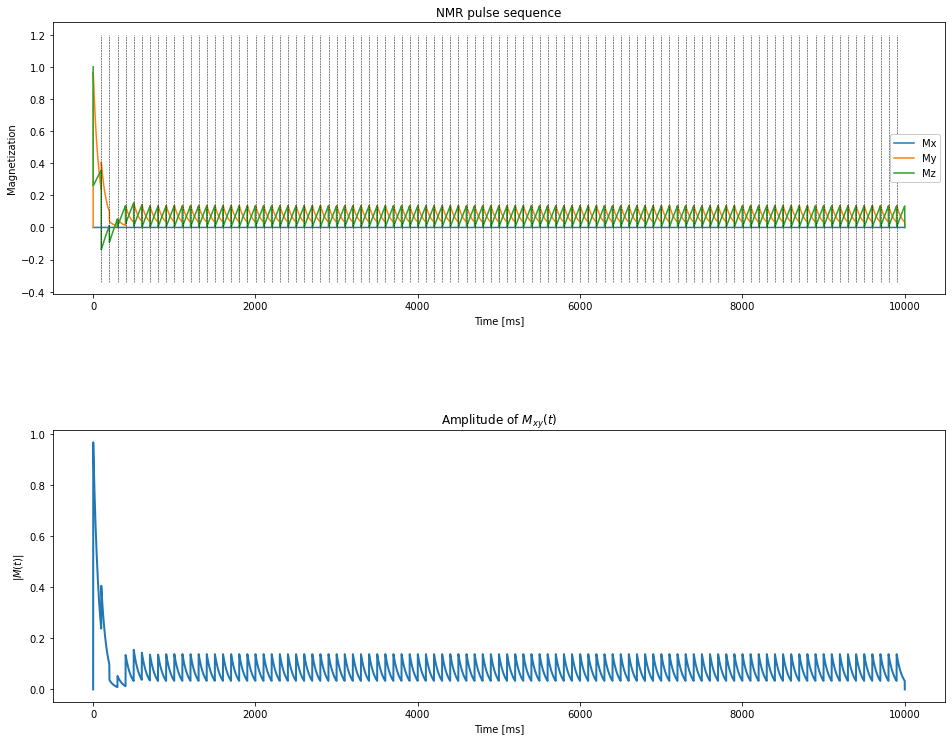

In [28]:
# RESULTS
time, M = magnetization_vectors(theta,inv_angle,T1,T2,dT,TE,TR_100,NEX_100);

plt.figure(figsize=(16,20));

# Magnetization plot
plt.subplot(3,1,1)
plt.plot(time, M[0,:], label = 'Mx');
plt.plot(time, M[1,:], label = 'My');
plt.plot(time, M[2,:], label = 'Mz');
for n in range(1,NEX_100):
    plt.plot([time[int(TR_100/dT*n+1)], time[int(TR_100/dT*n+1)]], 
             [np.min([M[0,:], M[1,:], M[2,:]])-0.2, np.max([M[0,:], M[1,:], M[2,:]])+0.2], 
             color='black', linestyle='dashed', linewidth=0.5);
plt.xlabel('Time [ms]');
plt.ylabel('Magnetization');
plt.title('NMR pulse sequence')
plt.legend(framealpha=1, frameon=True);
plt.subplots_adjust(hspace=0.5)

# Obtain amplitude and phase and plot results 
M_complex = np.zeros((len(M[0])),dtype=complex)
for i in range(len(M[0])):
    M_complex[i] = complex(M[0,i],M[1,i])
    
# Get amplitude and phase
M_abs = abs(M_complex)
M_arg = np.angle(M_complex)

plt.subplot(3,1,2)
plt.plot(time,M_abs,linewidth=2)
plt.xlabel('Time [ms]')
plt.ylabel('$|M(t)|$')
plt.title('Amplitude of $M_{xy}(t)$')
plt.subplots_adjust(hspace=0.5)
"""
plt.subplot(3,1,3)
plt.plot(time,M_arg)
plt.xlabel('Time [ms]')
plt.ylabel('$arg(M(t))$')
plt.title('Phase of $M_{xy}(t)$')
plt.show()
"""

### Transverse magnetization amplitude at each acquisition time

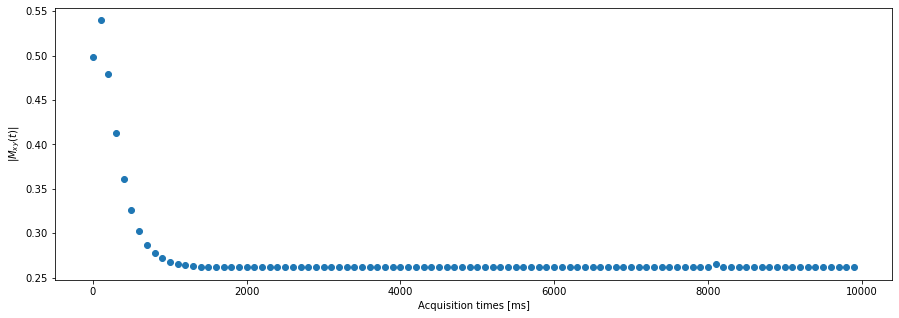

In [35]:
time_acq = []
M_acq    = []
for n in range(0,NEX_100):
    time_acq = time_acq + [time[int(n*TR_100/dT+1)]]
    M_acq    = M_acq + [M_abs[int(n*TR_100/dT+1)]]

plt.figure(figsize=(15,5));    
plt.scatter(time_acq,M_acq)
plt.xlabel('Acquisition times [ms]')
plt.ylabel('$|M_{xy}(t)|$')
plt.show()

### Calculation of the steady-state magnetization, $M_{SS}$

**THEORETICAL RESULT**

In [15]:
MzSS_theory = (1-np.exp(-TR_100/T1))/(1-np.exp(-TR_100/T1)*np.cos(theta))
print('MzSS = ' + str(MzSS_theory))

MxySS_theory = (1-np.exp(-TR_100/T1))/(1-np.exp(-TR_100/T1)*np.cos(theta)) * np.sin(theta)*np.exp(-TE/T2)
print('MxySS = ' + str(MxySS_theory))

MzSS = 0.17162971783298492
MxySS = 0.16343010499015792


**EXPERIMENTAL RESULT**

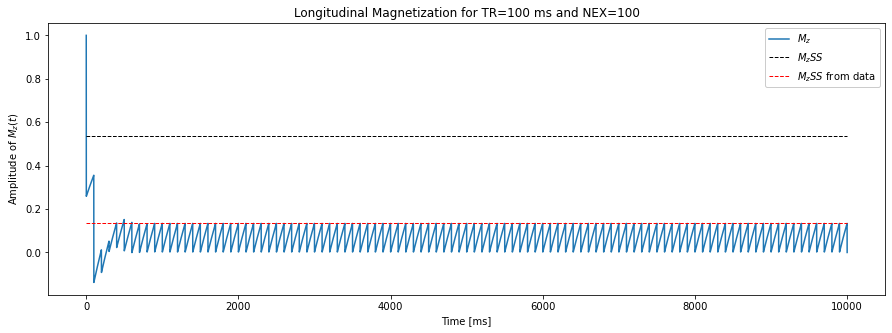

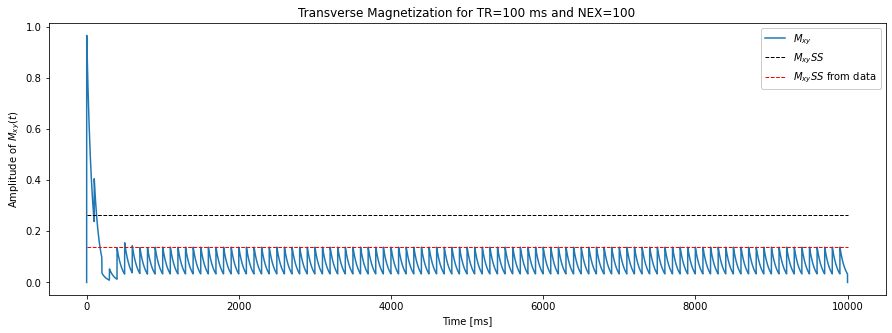

In [30]:
times_MzSS = argrelextrema(M[2,:], np.greater)[0]
MzSS6 = M[2,times_MzSS]

times_MxySS = argrelextrema(M_abs, np.greater)[0]
MxySS6 = M_abs[times_MxySS]

plt.figure(figsize=(15,5))

plt.plot(time, M[2,:], label = '$M_z$');
    
plt.plot([time[0], time[-1]], 
             [MzSS_theory, MzSS_theory], 
             color='black', linestyle='dashed', linewidth=1, label = '$M_{z}SS$');
plt.plot([time[0], time[-1]], 
             [MzSS6[-1], MzSS6[-1]], 
             color='red', linestyle='dashed', linewidth=1, label = '$M_{z}SS$ from data');
plt.title('Longitudinal Magnetization for TR=100 ms and NEX=100')
plt.xlabel('Time [ms]')
plt.ylabel('Amplitude of $M_z(t)$')
plt.legend(framealpha=1, frameon=True);
plt.show()

plt.figure(figsize=(15,5)) 
plt.plot(time, M_abs, label = '$M_{xy}$');
plt.plot([time[0], time[-1]], 
             [MxySS_theory, MxySS_theory], 
             color='black', linestyle='dashed', linewidth=1, label = '$M_{xy}SS$');
plt.plot([time[0], time[-1]], 
             [MxySS6[-1], MxySS6[-1]], 
             color='red', linestyle='dashed', linewidth=1, label = '$M_{xy}SS$ from data');
plt.title('Transverse Magnetization for TR=100 ms and NEX=100')
plt.xlabel('Time [ms]')
plt.ylabel('Amplitude of $M_{xy}(t)$')
plt.legend(framealpha=1, frameon=True);
plt.show()

In [17]:
# SÓ FIZ ISTO PORQUE OS PONTOS NO GRAFICO FICAM COMPLETAMENTE ILEGIVEIS, MAS NAO SEI SE ISTO VALE A 
# PENA OU SE É "CORRETO" DE SE APRESENTAR 

print('--> Longitudinal steady-state magnetization, MzSS:')
diff_MzSS = np.diff(np.round(MzSS6,2)) 
index = []
index_interval = []
for n in range(len(diff_MzSS)):
    if diff_MzSS[n] !=0:
        if n not in index:
            print(str(times_MzSS[n])+' s: M_zSS = ' + str(np.round(MzSS6[n],2)))
        if n+1 not in index and diff_MzSS[n+1] !=0:
            print(str(times_MzSS[n+1])+' s: M_zSS = ' + str(np.round(MzSS6[n+1],2)))
        
        index = index + [n, n+1]
        
    elif diff_MzSS[n] ==0 and diff_MzSS[n-1] !=0:
        print('['+ str(times_MzSS[n])+', ', end ="")
    
    elif diff_MzSS[n-1] ==0 and diff_MzSS[n] !=0:
        print(str(times_MzSS[n])+'] s: M_zSS = ' + str(np.round(MzSS6[n],2)))
    
    elif diff_MzSS[n-1] ==0 and n == len(diff_MzSS)-1:
        print(str(times_MzSS[n+1])+'] s: M_zSS = ' + str(np.round(MzSS6[n+1],2)))
        
print('\n--> Transverse steady-state magnetization, MxySS:')
diff_MxySS = np.diff(np.round(MxySS6,2)) 
index = []
index_interval = []
for n in range(len(diff_MxySS)):
    if diff_MxySS[n] !=0:
        if n not in index:
            print(str(times_MxySS[n])+' s: M_xySS = ' + str(np.round(MxySS6[n],2)))
        if n+1 not in index and diff_MzSS[n+1] !=0:
            print(str(times_MxySS[n+1])+' s: M_xySS = ' + str(np.round(MxySS6[n+1],2)))
        
        index = index + [n, n+1]
        
    elif diff_MxySS[n] ==0 and diff_MxySS[n-1] !=0:
        print('['+ str(times_MxySS[n])+', ', end ="")
    
    elif diff_MxySS[n-1] ==0 and diff_MxySS[n] !=0:
        print(str(times_MxySS[n])+'] s: M_xySS = ' + str(np.round(MxySS6[n],2)))
    
    elif diff_MxySS[n-1] ==0 and n == len(diff_MxySS)-1:
        print(str(times_MxySS[n+1])+'] s: M_xySS = ' + str(np.round(MxySS6[n+1],2)))

--> Longitudinal steady-state magnetization, MzSS:
99 s: M_zSS = 0.36
199 s: M_zSS = 0.01
299 s: M_zSS = 0.05
399 s: M_zSS = 0.14
499 s: M_zSS = 0.15
599 s: M_zSS = 0.14
[699, 9999] s: M_zSS = 0.13

--> Transverse steady-state magnetization, MxySS:
1 s: M_xySS = 0.97
100 s: M_xySS = 0.41
300 s: M_xySS = 0.05
400 s: M_xySS = 0.13
500 s: M_xySS = 0.16
600 s: M_xySS = 0.14
[600, 9900] s: M_xySS = 0.14


# 7) Computation of the Ernst angle for $TR = 1000\,ms$ and $TR = 100\,ms$

### Ernst angle for  𝑇𝑅=1000𝑚𝑠

In [18]:
ernst_angle= np.arccos(np.exp(-TR/T1)) * 180/np.pi
print('Ernst Angle = ' + str(ernst_angle))

Ernst Angle = 76.13405482642727


### Ernst angle for  𝑇𝑅=100𝑚𝑠

In [19]:
ernst_angle_100= np.arccos(np.exp(-TR_100/T1)) * 180/np.pi
print('Ernst Angle = ' + str(ernst_angle_100))

Ernst Angle = 29.902166438970397


# 8) Evolution of the longitudinal and transverse magnetization and steady-state magnetization calculation for $TR = 100\,ms$ using the Ernst angle

### Evolution of the longitudinal and transverse magnetization

"\nplt.subplot(3,1,3)\nplt.plot(time,M_arg)\nplt.xlabel('Time [ms]')\nplt.ylabel('$arg(M(t))$')\nplt.title('Phase of $M_{xy}(t)$')\nplt.show()\n"

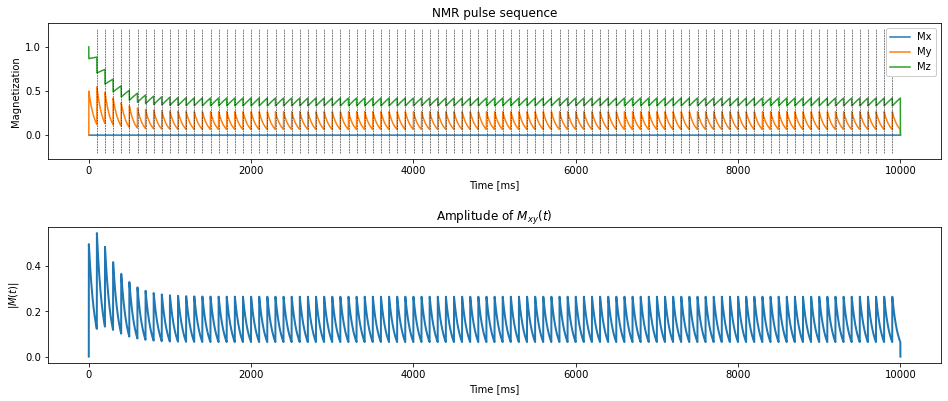

In [32]:
relax = ernst_angle_100*np.pi/180
time, M = magnetization_vectors(relax,inv_angle,T1,T2,dT,TE,TR_100,NEX_100);

plt.figure(figsize=(16,10));
# Magnetization plot
plt.subplot(3,1,1)
plt.plot(time, M[0,:], label = 'Mx');
plt.plot(time, M[1,:], label = 'My');
plt.plot(time, M[2,:], label = 'Mz');
for n in range(1,NEX_100):
    plt.plot([time[int(TR_100/dT*n+1)], time[int(TR_100/dT*n+1)]], 
             [np.min([M[0,:], M[1,:], M[2,:]])-0.2, np.max([M[0,:], M[1,:], M[2,:]])+0.2], 
             color='black', linestyle='dashed', linewidth=0.5);
plt.xlabel('Time [ms]');
plt.ylabel('Magnetization');
plt.title('NMR pulse sequence')
plt.legend(framealpha=1, frameon=True);
plt.subplots_adjust(hspace=0.5)

# Obtain amplitude and phase and plot results 
M_complex = np.zeros((len(M[0])),dtype=complex)
for i in range(len(M[0])):
    M_complex[i] = complex(M[0,i],M[1,i])
    
# Get amplitude and phase
M_abs = abs(M_complex)
M_arg = np.angle(M_complex)

plt.subplot(3,1,2)
plt.plot(time,M_abs,linewidth=2)
plt.xlabel('Time [ms]')
plt.ylabel('$|M(t)|$')
plt.title('Amplitude of $M_{xy}(t)$')
plt.subplots_adjust(hspace=0.5)
"""
plt.subplot(3,1,3)
plt.plot(time,M_arg)
plt.xlabel('Time [ms]')
plt.ylabel('$arg(M(t))$')
plt.title('Phase of $M_{xy}(t)$')
plt.show()
"""

### Transverse magnetization amplitude at each acquisition time

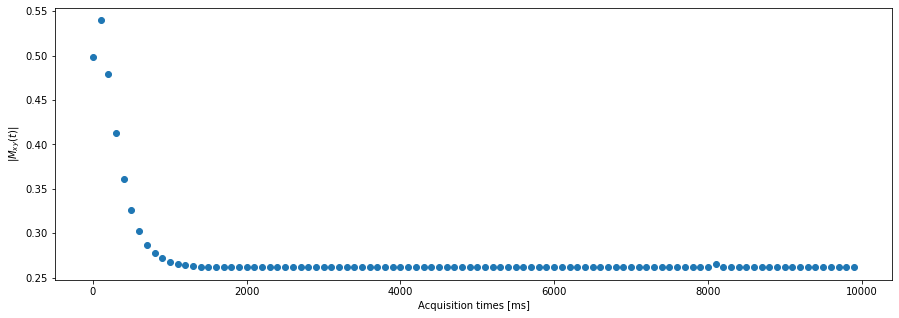

In [34]:
time_acq = []
M_acq    = []
for n in range(0,NEX_100):
    time_acq = time_acq + [time[int(n*TR_100/dT+1)]]
    M_acq    = M_acq + [M_abs[int(n*TR_100/dT+1)]]

plt.figure(figsize=(15,5));    
plt.scatter(time_acq,M_acq)
plt.xlabel('Acquisition times [ms]')
plt.ylabel('$|M_{xy}(t)|$')
plt.show()

### Calculation of the steady-state magnetization, $M_{SS}$

**THEORETICAL RESULT**

In [23]:
MzSS_theory = (1-np.exp(-TR_100/T1))/(1-np.exp(-TR_100/T1)*np.cos(relax))
print('MzSS = ' + str(MzSS_theory))

MxySS_theory = (1-np.exp(-TR_100/T1))/(1-np.exp(-TR_100/T1)*np.cos(relax)) * np.sin(relax)*np.exp(-TE/T2)
print('MxySS = ' + str(MxySS_theory))

MzSS = 0.5356536708339716
MxySS = 0.26324668823010167


**EXPERIMENTAL RESULT**

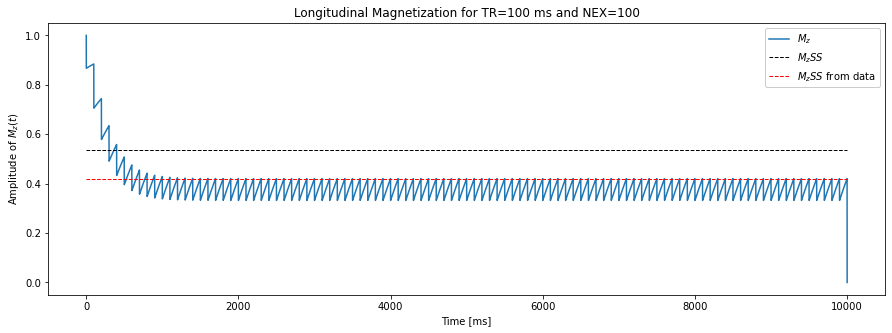

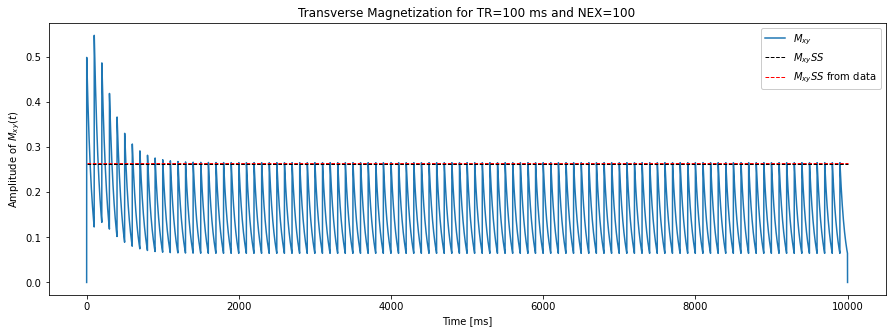

In [33]:
times_MzSS = argrelextrema(M[2,:], np.greater)[0]
MzSS8 = M[2,times_MzSS]

times_MxySS = argrelextrema(M_abs, np.greater)[0]
MxySS8 = M_abs[times_MxySS]


plt.figure(figsize=(15,5))

plt.plot(time, M[2,:], label = '$M_z$');
    
plt.plot([time[0], time[-1]], 
             [MzSS_theory, MzSS_theory], 
             color='black', linestyle='dashed', linewidth=1, label = '$M_{z}SS$');
plt.plot([time[0], time[-1]], 
             [MzSS8[-1], MzSS8[-1]], 
             color='red', linestyle='dashed', linewidth=1, label = '$M_{z}SS$ from data');
plt.title('Longitudinal Magnetization for TR=100 ms and NEX=100')
plt.xlabel('Time [ms]')
plt.ylabel('Amplitude of $M_z(t)$')
plt.legend(framealpha=1, frameon=True);
plt.show()

plt.figure(figsize=(15,5)) 
plt.plot(time, M_abs, label = '$M_{xy}$');
plt.plot([time[0], time[-1]], 
             [MxySS_theory, MxySS_theory], 
             color='black', linestyle='dashed', linewidth=1, label = '$M_{xy}SS$');
plt.plot([time[0], time[-1]], 
             [MxySS8[-1], MxySS8[-1]], 
             color='red', linestyle='dashed', linewidth=1, label = '$M_{xy}SS$ from data');
plt.title('Transverse Magnetization for TR=100 ms and NEX=100')
plt.xlabel('Time [ms]')
plt.ylabel('Amplitude of $M_{xy}(t)$')
plt.legend(framealpha=1, frameon=True);
plt.show()

# 9) Variation of the SNR with $NEX$ and $M_{SS}$

The noise in MRI images arises from random thermal motion in conductors (the coil and the body sample) and it is Gaussian Noise. Thus, the SNR varies with the number of repetitions in an experiment as:

$$SNR(N_{av}) = \sqrt{N_{av}} SNR$$

In [25]:
SNR6v5=(np.sqrt(100)*MxySS6[-1])/(np.sqrt(10)*MxySS5[-1])
print(SNR6v5)

SNR8v5=(np.sqrt(100)*MxySS8[-1])/(np.sqrt(10)*MxySS5[-1])
print(SNR8v5)

0.5573326125174686
1.0721283697374904
